In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
import joblib

## Preprocessing Data

### Import data

In [125]:
df = pd.read_csv('../Data/PGH/DemandPrediction/learning_set_unnormalized.csv')
df.head(4)

,Unnamed: 0,index,walk_score,bike_score,transit_score,temp,month,year,outflow
0,0,38,76,82,86,73.0,JUL,2018,1
1,1,39,76,82,86,69.7,AUG,2018,0
2,2,40,76,82,86,53.4,SEP,2018,0
3,3,41,76,82,86,37.3,OCT,2018,0


In [126]:
df = df.drop(columns=['Unnamed: 0', 'index', 'year'])
y = df.iloc[:,5].to_numpy()
print(y)
df = pd.get_dummies(df,columns=['month'],drop_first=True)
df = df.drop(columns=['outflow'])
df.head()

[1 0 0 ... 6 3 0]


,walk_score,bike_score,transit_score,temp,month_AUG,month_DEC,month_FEB,month_JAN,month_JUL,month_JUN,month_MAR,month_MAY,month_NOV,month_OCT,month_SEP
0,76,82,86,73.0,0,0,0,0,1,0,0,0,0,0,0
1,76,82,86,69.7,1,0,0,0,0,0,0,0,0,0,0
2,76,82,86,53.4,0,0,0,0,0,0,0,0,0,0,1
3,76,82,86,37.3,0,0,0,0,0,0,0,0,0,1,0
4,76,82,86,34.9,0,0,0,0,0,0,0,0,1,0,0


In [55]:
#try to filter out outflow that is only greater than 0
# df_filter = df[df['outflow']>0]
# len(df_filter)

In [ ]:
# len(df)

In [ ]:
# plt.scatter(df_filter['bike_score'], df_filter['outflow'], s=1); plt.show()

### Split data for training and test

We have a small number of locations that have bike stations. First, we need to filter out any cell that does not have any stations.

In [127]:
X = df.iloc[:, :].to_numpy() #only use this line if using the first and second code cell

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Perform Feature Scaling

## Defining Models
Code from https://towardsdatascience.com/end-to-end-case-study-bike-sharing-demand-dataset-53201926c8db

In [128]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=0)
dt_params = {'max_depth':np.arange(1,50,2),'min_samples_leaf':np.arange(2,15)}

from sklearn.model_selection import GridSearchCV
gs_dt = GridSearchCV(dt,dt_params,cv=3)
gs_dt.fit(X_train,y_train)
a = gs_dt.best_params_

In [129]:
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor(max_depth=a['max_depth'],min_samples_leaf= a['min_samples_leaf'])
model = dtr.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For decision tree

RMLSE for the data: 0.968352651329183


In [130]:
# save the model to disk
filename = 'saved_models/decision_tree_dummies.sav'
joblib.dump(model, filename)

['decision_tree_dummies.sav']

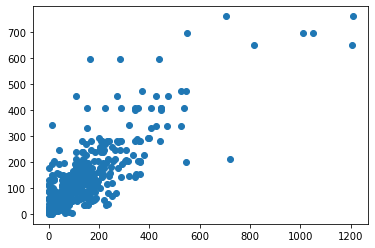

In [131]:
plt.scatter(y_test, y_pred)
plt.show()

In [132]:
#Random Forest
rf = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}

from sklearn.model_selection import GridSearchCV
gs_rf = GridSearchCV(rf,rf_params,cv=3)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_

In [133]:
RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'],random_state=0)
model = RF.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For random forest

RMLSE for the data: 0.9136267247059643


In [134]:
# save the model to disk
filename = 'saved_models/random_forest_dummies.sav'
joblib.dump(model, filename)

['saved_models/random_forest_dummies.sav']

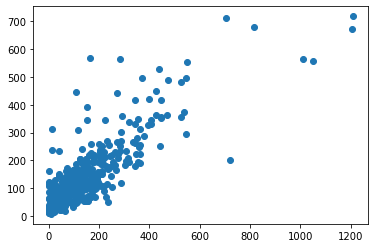

In [135]:
plt.scatter(y_test, y_pred)
plt.show()

In [136]:
#Adaboost Regressor
from sklearn.ensemble import AdaBoostRegressor
ar = AdaBoostRegressor(base_estimator=RF,random_state=0)
ar_params = {'n_estimators':np.arange(25,200,25)}

gs_ar = GridSearchCV(ar,ar_params,cv=3)
gs_ar.fit(X_train,y_train)
c = gs_ar.best_params_

In [137]:
ab_rf = AdaBoostRegressor(base_estimator=RF,n_estimators=c['n_estimators'],random_state=0)
model = ab_rf.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMSLE for the data:',rmsle) # For Ada-Boost

RMSLE for the data: 0.9723812764755068


In [138]:
# save the model to disk
filename = 'saved_models/adaboost_dummies.sav'
joblib.dump(model, filename)

['saved_models/adaboost_dummies.sav']

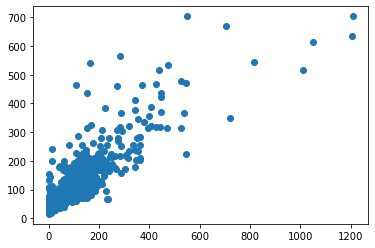

In [139]:
plt.scatter(y_test, y_pred)
plt.show()

----

Getting rid of the one hot encoding

In [140]:
df = pd.read_csv('../Data/PGH/DemandPrediction/learning_set_unnormalized.csv')
df = df.drop(columns=['Unnamed: 0', 'index', 'year', 'month'])
df.head()

,walk_score,bike_score,transit_score,temp,outflow
0,76,82,86,73.0,1
1,76,82,86,69.7,0
2,76,82,86,53.4,0
3,76,82,86,37.3,0
4,76,82,86,34.9,0


In [141]:
X = df.iloc[:, :4].to_numpy()
y = df.iloc[:,4].to_numpy() #add this line only if you did not define y in the second code cell make sure to change the values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [142]:
y = df.iloc[:,4].to_numpy()
y

array([1, 0, 0, ..., 6, 3, 0])

In [143]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeRegressor(random_state=0)
dt_params = {'max_depth':np.arange(1,50,2),'min_samples_leaf':np.arange(2,15)}

gs_dt = GridSearchCV(dt,dt_params,cv=3)
gs_dt.fit(X_train,y_train)
a = gs_dt.best_params_

dtr=DecisionTreeRegressor(max_depth=a['max_depth'],min_samples_leaf= a['min_samples_leaf'])
model = dtr.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For decision tree

RMLSE for the data: 0.9266363582121049


In [144]:
# save the model to disk
filename = 'saved_models/decision_tree_nodummies.sav'
joblib.dump(model, filename)

['saved_models/decision_tree_nodummies.sav']

In [145]:
np.mean(y_test)

121.76271186440678

In [146]:
#Random Forest
rf = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}

gs_rf = GridSearchCV(rf,rf_params,cv=3)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_

RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'],random_state=0)
model = RF.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For random forest

RMLSE for the data: 0.9131260289911332


In [147]:
# save the model to disk
filename = 'saved_models/random_forest_nodummies.sav'
joblib.dump(model, filename)

['saved_models/random_forest_nodummies.sav']

In [148]:
np.mean(y_test)

121.76271186440678

In [149]:
#Adaboost Regressor
from sklearn.ensemble import AdaBoostRegressor
ar = AdaBoostRegressor(base_estimator=RF,random_state=0)
ar_params = {'n_estimators':np.arange(25,200,25)}

gs_ar = GridSearchCV(ar,ar_params,cv=3)
gs_ar.fit(X_train,y_train)
c = gs_ar.best_params_

ab_rf = AdaBoostRegressor(base_estimator=RF,n_estimators=c['n_estimators'],random_state=0)
model = ab_rf.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMSLE for the data:',rmsle) # For Ada-Boost

RMSLE for the data: 1.023791335332397


In [150]:
# save the model to disk
filename = 'saved_models/adaboost_nodummies.sav'
joblib.dump(model, filename)

['saved_models/adaboost_nodummies.sav']

In [151]:
np.mean(y_test)

121.76271186440678

|  | RMSLE|
|:--:|:--:|
|Decision Tree| 0.967|
|Random Forest| 0.914|
|AdaBoost| 0.972|

when taking our month and year, the models get the following RMSLE:

|  | RMSLE|
|:--:|:--:|
|Decision Tree| |
|Random Forest| |
|AdaBoost| |

Trying a different verison of Df

In [152]:
df = pd.read_csv('../Data/PGH/DemandPrediction/learning_set_unnormalized.csv')
df = df.drop(columns=['Unnamed: 0', 'index', 'month', 'year'])

#filtering out any spot where outflow is greater than 0
df_filter = df[df['outflow']>0]

X = df_filter.iloc[:, :4].to_numpy()
y = df_filter.iloc[:,4].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Random Forest
rf = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}

gs_rf = GridSearchCV(rf,rf_params,cv=3)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_

RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'],random_state=0)
model = RF.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle)

RMLSE for the data: 0.7884859620609537


In [153]:
# save the model to disk
filename = 'saved_models/random_forest_nodummies_nozeros.sav'
joblib.dump(model, filename)

['saved_models/random_forest_nodummies_nozeros.sav']

import plotly.express as px

fig = px.scatter(df, y_test, y_pred, labels={'x':'ground truth', 
                          'y': 'predicted demand'},title="Random Forest")
fig.show()

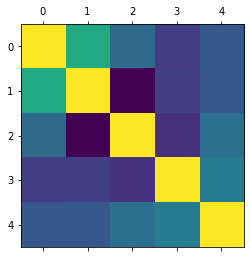

In [28]:
plt.matshow(df.corr())
plt.show()

___

Using data set with spatial attributes - i.e. number of stations and station capacity

In [154]:
df = pd.read_csv('../Data/PGH/DemandPrediction/learning_set_spatial.csv')
df = df.drop(columns=['Unnamed: 0', 'index', 'year', 'month'])
df.head(4)

,stations,capacity,walk_score,bike_score,transit_score,temp,outflow
0,1,10,76,82,86,73.0,1
1,1,10,76,82,86,69.7,0
2,1,10,76,82,86,53.4,0
3,1,10,76,82,86,37.3,0


In [155]:
X = df.iloc[:, :6].to_numpy()
y = df.iloc[:,6].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [156]:
y = df.iloc[:,6].to_numpy()
y

array([1, 0, 0, ..., 6, 3, 0])

In [157]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeRegressor(random_state=0)
dt_params = {'max_depth':np.arange(1,50,2),'min_samples_leaf':np.arange(2,15)}

gs_dt = GridSearchCV(dt,dt_params,cv=3)
gs_dt.fit(X_train,y_train)
a = gs_dt.best_params_

dtr=DecisionTreeRegressor(max_depth=a['max_depth'],min_samples_leaf= a['min_samples_leaf'])
model = dtr.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For decision tree

RMLSE for the data: 0.8161503049739915


In [158]:
# save the model to disk
filename = 'saved_models/decision_tree_spatial.sav'
joblib.dump(model, filename)

['saved_models/decision_tree_spatial.sav']

In [159]:
np.mean(y_test)

121.76271186440678

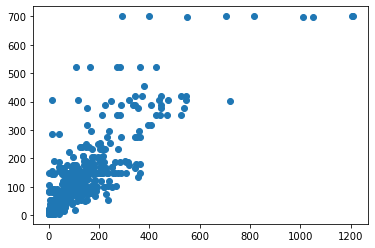

In [160]:
plt.scatter(y_test, y_pred)
plt.show()

In [161]:
#Random Forest
rf = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}

gs_rf = GridSearchCV(rf,rf_params,cv=3)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_

RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'],random_state=0)
model = RF.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For random forest

RMLSE for the data: 0.8043421418992356


In [162]:
# save the model to disk
filename = 'saved_models/random_forest_spatial.sav'
joblib.dump(model, filename)

['saved_models/random_forest_spatial.sav']

In [163]:
#Adaboost Regressor
from sklearn.ensemble import AdaBoostRegressor
ar = AdaBoostRegressor(base_estimator=RF,random_state=0)
ar_params = {'n_estimators':np.arange(25,200,25)}

gs_ar = GridSearchCV(ar,ar_params,cv=3)
gs_ar.fit(X_train,y_train)
c = gs_ar.best_params_

ab_rf = AdaBoostRegressor(base_estimator=RF,n_estimators=c['n_estimators'],random_state=0)
model = ab_rf.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMSLE for the data:',rmsle) # For Ada-Boost

RMSLE for the data: 0.9498907600309728


In [164]:
# save the model to disk
filename = 'saved_models/adaboost_spatial.sav'
joblib.dump(model, filename)

['saved_models/adaboost_spatial.sav']

---

Getting rid of capacity and just leaving stations

In [165]:
df = pd.read_csv('../Data/PGH/DemandPrediction/learning_set_spatial.csv')
df = df.drop(columns=['Unnamed: 0', 'capacity','index', 'year', 'month'])
df.head(4)

,stations,walk_score,bike_score,transit_score,temp,outflow
0,1,76,82,86,73.0,1
1,1,76,82,86,69.7,0
2,1,76,82,86,53.4,0
3,1,76,82,86,37.3,0


In [166]:
X = df.iloc[:, :5].to_numpy()
y = df.iloc[:,5].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [167]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeRegressor(random_state=0)
dt_params = {'max_depth':np.arange(1,50,2),'min_samples_leaf':np.arange(2,15)}

gs_dt = GridSearchCV(dt,dt_params,cv=3)
gs_dt.fit(X_train,y_train)
a = gs_dt.best_params_

dtr=DecisionTreeRegressor(max_depth=a['max_depth'],min_samples_leaf= a['min_samples_leaf'])
model = dtr.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For decision tree
print(np.mean(y_test))

RMLSE for the data: 0.90412181469817
121.76271186440678


In [168]:
# save the model to disk
filename = 'saved_models/decision_tree_spatial2.sav'
joblib.dump(model, filename)

['saved_models/decision_tree_spatial2.sav']

In [169]:
#Random Forest
rf = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}

gs_rf = GridSearchCV(rf,rf_params,cv=3)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_

RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'],random_state=0)
model = RF.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For random forest
print(np.mean(y_test))

RMLSE for the data: 0.8910642894916045
121.76271186440678


In [170]:
# save the model to disk
filename = 'saved_models/random_forest_spatial2.sav'
joblib.dump(model, filename)

['saved_models/random_forest_spatial2.sav']

In [171]:
#Adaboost Regressor
from sklearn.ensemble import AdaBoostRegressor
ar = AdaBoostRegressor(base_estimator=RF,random_state=0)
ar_params = {'n_estimators':np.arange(25,200,25)}

gs_ar = GridSearchCV(ar,ar_params,cv=3)
gs_ar.fit(X_train,y_train)
c = gs_ar.best_params_

ab_rf = AdaBoostRegressor(base_estimator=RF,n_estimators=c['n_estimators'],random_state=0)
model = ab_rf.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMSLE for the data:',rmsle) # For Ada-Boost
print(np.mean(y_test))

RMSLE for the data: 1.0124966738506869
121.76271186440678


In [172]:
# save the model to disk
filename = 'saved_models/adaboost_spatial2.sav'
joblib.dump(model, filename)

['saved_models/adaboost_spatial2.sav']

----

### Spataially sensitive training set

In [173]:
df = pd.read_csv('../Data/PGH/DemandPrediction/spatially_sensitive_train.csv')
df = df.drop(columns=['Unnamed: 0', 'capacity','index', 'year', 'month', 'stationList', 'cell_num', 'nearby'])

#labels
y = df['outflow'].values
df = df.drop(columns=['outflow'])
X = df.iloc[:, :].to_numpy()

df.head(5)

,stations,walk_score,bike_score,transit_score,temp,N,S,E,W,NW,NE,SW,SE,nearby_routes
0,1,76,82,86,73.0,0,0,0,0,0,0,0,0,63
1,1,76,82,86,69.7,0,0,0,0,0,0,0,0,63
2,1,76,82,86,53.4,3,0,0,0,0,3,0,0,63
3,1,76,82,86,37.3,3,0,0,0,0,3,0,0,63
4,1,76,82,86,34.9,3,0,0,0,0,3,0,0,63


In [174]:
y

array([1, 0, 0, ..., 6, 3, 0])

In [175]:
X

array([[ 1., 76., 82., ...,  0.,  0., 63.],
       [ 1., 76., 82., ...,  0.,  0., 63.],
       [ 1., 76., 82., ...,  0.,  0., 63.],
       ...,
       [ 1., 60., 74., ...,  0.,  0., 26.],
       [ 1., 60., 74., ...,  0.,  0., 26.],
       [ 1., 60., 74., ...,  0.,  0., 26.]])

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [177]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeRegressor(random_state=0)
dt_params = {'max_depth':np.arange(1,50,2),'min_samples_leaf':np.arange(2,15)}

gs_dt = GridSearchCV(dt,dt_params,cv=3)
gs_dt.fit(X_train,y_train)
a = gs_dt.best_params_

dtr=DecisionTreeRegressor(max_depth=a['max_depth'],min_samples_leaf= a['min_samples_leaf'])
model = dtr.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For decision tree
print(np.mean(y_pred))

RMLSE for the data: 0.8832232814410339
124.61115830863774


In [178]:
# save the model to disk
filename = 'saved_models/decision_tree_spatial_sensitive.sav'
joblib.dump(model, filename)

['saved_models/decision_tree_spatial_sensitive.sav']

In [179]:
#Random Forest
rf = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}

gs_rf = GridSearchCV(rf,rf_params,cv=3)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_

RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'],random_state=0)
model = RF.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For random forest
print(np.mean(y_pred))

RMLSE for the data: 0.878890196310382
122.39902834270788


In [180]:
# save the model to disk
filename = 'saved_models/random_forest_spatial_sensitive.sav'
joblib.dump(model, filename)

['saved_models/random_forest_spatial_sensitive.sav']

In [181]:
#Adaboost Regressor
from sklearn.ensemble import AdaBoostRegressor
ar = AdaBoostRegressor(base_estimator=RF,random_state=0)
ar_params = {'n_estimators':np.arange(25,200,25)}

gs_ar = GridSearchCV(ar,ar_params,cv=3)
gs_ar.fit(X_train,y_train)
c = gs_ar.best_params_

ab_rf = AdaBoostRegressor(base_estimator=RF,n_estimators=c['n_estimators'],random_state=0)
model = ab_rf.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMSLE for the data:',rmsle) # For Ada-Boost
print(np.mean(y_pred))

RMSLE for the data: 0.9952237597397655
132.9048977833412


In [182]:
# save the model to disk
filename = 'saved_models/adaboost_spatial_sensitive.sav'
joblib.dump(model, filename)

['saved_models/adaboost_spatial_sensitive.sav']

----

Taking the stations attribute out...I don't think we want that. 

In [183]:
df = pd.read_csv('../Data/PGH/DemandPrediction/spatially_sensitive_train.csv')
df = df.drop(columns=['Unnamed: 0', 'stations','capacity','index', 'year', 'month', 'stationList', 'cell_num', 'nearby'])

#labels
y = df['outflow'].values
df = df.drop(columns=['outflow'])
X = df.iloc[:, :].to_numpy()

df.head(5)

,walk_score,bike_score,transit_score,temp,N,S,E,W,NW,NE,SW,SE,nearby_routes
0,76,82,86,73.0,0,0,0,0,0,0,0,0,63
1,76,82,86,69.7,0,0,0,0,0,0,0,0,63
2,76,82,86,53.4,3,0,0,0,0,3,0,0,63
3,76,82,86,37.3,3,0,0,0,0,3,0,0,63
4,76,82,86,34.9,3,0,0,0,0,3,0,0,63


In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [185]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeRegressor(random_state=0)
dt_params = {'max_depth':np.arange(1,50,2),'min_samples_leaf':np.arange(2,15)}

gs_dt = GridSearchCV(dt,dt_params,cv=3)
gs_dt.fit(X_train,y_train)
a = gs_dt.best_params_

dtr=DecisionTreeRegressor(max_depth=a['max_depth'],min_samples_leaf= a['min_samples_leaf'])
model = dtr.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For decision tree
print(np.mean(y_pred))

RMLSE for the data: 0.9078563992774833
125.72487002383251


In [186]:
# save the model to disk
filename = 'saved_models/decision_tree_spatial_sensitive2.sav'
joblib.dump(model, filename)

['saved_models/decision_tree_spatial_sensitive2.sav']

In [187]:
#Random Forest
rf = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}

gs_rf = GridSearchCV(rf,rf_params,cv=3)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_

RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'],random_state=0)
model = RF.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For random forest
print(np.mean(y_pred))

RMLSE for the data: 0.9048022253814225
123.38639137662969


In [188]:
# save the model to disk
filename = 'saved_models/random_forest_spatial_sensitive2.sav'
joblib.dump(model, filename)

['saved_models/random_forest_spatial_sensitive2.sav']

In [189]:
#Adaboost Regressor
from sklearn.ensemble import AdaBoostRegressor
ar = AdaBoostRegressor(base_estimator=RF,random_state=0)
ar_params = {'n_estimators':np.arange(25,200,25)}

gs_ar = GridSearchCV(ar,ar_params,cv=3)
gs_ar.fit(X_train,y_train)
c = gs_ar.best_params_

ab_rf = AdaBoostRegressor(base_estimator=RF,n_estimators=c['n_estimators'],random_state=0)
model = ab_rf.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMSLE for the data:',rmsle) # For Ada-Boost
print(np.mean(y_pred))

RMSLE for the data: 1.0138594822924447
133.18009645234318


In [190]:
# save the model to disk
filename = 'saved_models/adaboost_spatial_sensitive.sav'
joblib.dump(model, filename)

['saved_models/adaboost_spatial_sensitive.sav']

In [122]:
# def get_model_performance(X_test, y_true, y_pred, probs):
#     accuracy = accuracy_score(y_true, y_pred)
#     matrix = confusion_matrix(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred)
#     preds = probs[:, 1]
#     fpr, tpr, threshold = roc_curve(y_true, preds)
#     roc_auc = auc(fpr, tpr)

#     return accuracy, matrix, f1, fpr, tpr, roc_auc

# def plot_model_performance(model, X_test, y_true):
#     y_pred = model.predict(X_test)
#     probs = model.predict_proba(X_test)
#     accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

#     display(Markdown('#### Accuracy of the model :'))
#     print(accuracy)
#     display(Markdown('#### F1 score of the model :'))
#     print(f1)

#     fig = plt.figure(figsize=(15, 6))
#     ax = fig.add_subplot(1, 2, 1)
#     sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
#     plt.title('Confusion Matrix')

#     ax = fig.add_subplot(1, 2, 2)
#     lw = 2
#     plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic curve')
#     plt.legend(loc="lower right")

In [191]:
# plot_model_performance(RF, X_test.features, y_test)

---

Filtering out when outflow is 0

In [192]:
df = pd.read_csv('../Data/PGH/DemandPrediction/spatially_sensitive_train.csv')
df = df.drop(columns=['Unnamed: 0', 'stations','capacity','index', 'year', 'month', 'stationList', 'cell_num', 'nearby'])
df = df[df['outflow']>0]
#labels
y = df['outflow'].values
df = df.drop(columns=['outflow'])
X = df.iloc[:, :].to_numpy()

df.head(5)

,walk_score,bike_score,transit_score,temp,N,S,E,W,NW,NE,SW,SE,nearby_routes
0,76,82,86,73.0,0,0,0,0,0,0,0,0,63
9,76,82,86,37.7,3,0,0,0,0,3,0,0,63
10,76,82,86,35.4,3,0,0,0,0,3,0,0,63
11,76,82,86,52.4,3,0,0,0,0,3,0,0,63
12,76,82,86,73.2,0,0,0,0,0,0,0,0,63


In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [194]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeRegressor(random_state=0)
dt_params = {'max_depth':np.arange(1,50,2),'min_samples_leaf':np.arange(2,15)}

gs_dt = GridSearchCV(dt,dt_params,cv=3)
gs_dt.fit(X_train,y_train)
a = gs_dt.best_params_

dtr=DecisionTreeRegressor(max_depth=a['max_depth'],min_samples_leaf= a['min_samples_leaf'])
model = dtr.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For decision tree
print(np.mean(y_pred))

RMLSE for the data: 0.7426415318800693
117.20489611311413


In [195]:
# save the model to disk
filename = 'saved_models/decision_tree_spatial_sensitive_nozeros.sav'
joblib.dump(model, filename)

['saved_models/decision_tree_spatial_sensitive_nozeros.sav']

In [196]:
#Random Forest
rf = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}

gs_rf = GridSearchCV(rf,rf_params,cv=3)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_

RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'],random_state=0)
model = RF.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For random forest
print(np.mean(y_pred))

RMLSE for the data: 0.757308759053377
118.34324608344217


In [197]:
# save the model to disk
filename = 'saved_models/random_forest_spatial_sensitive_nozeros.sav'
joblib.dump(model, filename)

['saved_models/random_forest_spatial_sensitive_nozeros.sav']

In [198]:
#Adaboost Regressor
from sklearn.ensemble import AdaBoostRegressor
ar = AdaBoostRegressor(base_estimator=RF,random_state=0)
ar_params = {'n_estimators':np.arange(25,200,25)}

gs_ar = GridSearchCV(ar,ar_params,cv=3)
gs_ar.fit(X_train,y_train)
c = gs_ar.best_params_

ab_rf = AdaBoostRegressor(base_estimator=RF,n_estimators=c['n_estimators'],random_state=0)
model = ab_rf.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMSLE for the data:',rmsle) # For Ada-Boost
print(np.mean(y_pred))

RMSLE for the data: 0.8647012934723373
127.468696753917


In [199]:
# save the model to disk
filename = 'saved_models/adaboost_spatial_sensitive_nozeros.sav'
joblib.dump(model, filename)

['saved_models/adaboost_spatial_sensitive_nozeros.sav']